In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from nltk.tokenize import WordPunctTokenizer, RegexpTokenizer
from string import punctuation
import matplotlib.pyplot as plt
import re
from sklearn.metrics import accuracy_score

%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

Считываем данные из файла, задаем нужный разделитель ";" и смотрим наш датафрейм;


In [2]:
df_train = pd.read_csv("lang_labeled.csv", sep=";", error_bad_lines=False)
df_train.head()

,Text,Language
0,��👟👟В НАЛИЧИИ 👟👟👟 🇬🇧🇬🇧🇬🇧Reebok🇬🇧🇬🇧🇬🇧 В раз...,ru
1,"Роман Грищенко Кроссфит-атлет, вице-чемпион Бо...",ru
2,Предлагаю: Коньки фигурные Reebok за 2000руб. ...,ru
3,28 февраля на территории с. Ивантиеевка и Иван...,ru
4,Reebok 1000руб 36-41 маломерят на размер,ru


<IPython.core.display.Javascript object>

Проверяем много ли языков задействовано в данных;

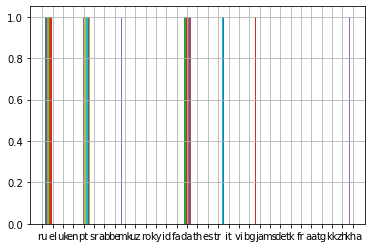

<IPython.core.display.Javascript object>

In [3]:
df_labels = df_train.groupby("Language").count()
df_labels

Много. Такая гистограмма нам не даст особо информации, посмотрим на все языки, которые используются в данных, 
а так же посмотрим, насколько равномерно распределены языки по датафрейму;

In [3]:
df_labels = df_train.groupby("Language").count()
df_labels

,Text
Language,
aa,11
ab,11
be,76
bg,206
da,81
de,37
el,12
en,1000
es,63


<IPython.core.display.Javascript object>

Чтож, видим что некоторые языки явно преобладают количеством;

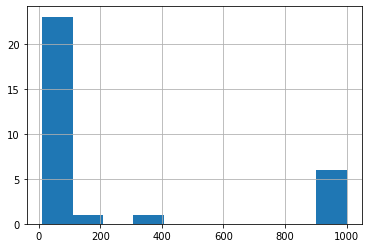

<IPython.core.display.Javascript object>

In [4]:
df_labels["Text"].hist()

По этой гистограмме можно сказать, что языков, на которых дано менее 100 экземпляров текста, 
гораздо больше чем языков, на которых дано около 1000;

Далее обработаем наши текстовые данные, с помощью токенизации разобьем тексты на токены (слова, знаки и тд).
Уберем из них знаки пунктуации, #хештеги и @ссылки, приведем к нижнему регистру;
Уточню, что удаление смайликов таким методом привело к чуть более худшему результату, так как пострадали некоторые тексты,например японский. Поэтому было решено оставить их.
Так как некоторые тексты стостояли только из хештегов и ссылок, в данных появились пробелы, для того чтобы восполнить пробелы и оставить хоть какую то информацию, было решено пустые строки заменить на те хештеги и ссылки, которые были в изначальном тексте, предварительно убрав знаки @ и #.

In [5]:
def delete_hashtags(text):
    temp = []
    hashtag_pattern = re.compile("#\S+")
    at_pattern = re.compile("@\S+")
    for i in text:
        h = hashtag_pattern.sub(r"", str(i.split(" ")))
        a = at_pattern.sub(r"", h)
        temp.append(a)
    return temp


def preprocess_text(text):
    temp = []
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )

    for i in text:
        tokenizer = RegexpTokenizer(r"\w+")
        tokens = tokenizer.tokenize(str(i).lower())
        tokens = [
            token
            for token in tokens
            if token != " " and token.strip() not in punctuation
            #             and emoji_pattern.sub(r"", token)
            and re.sub(r"\d+", "", token)
        ]

        i = " ".join(tokens)
        temp.append(i)
    return temp


def null_tokens(text):
    temp = []
    for k, i in enumerate(text):
        if i == "":
            i = re.sub(r"", df_train.Text[k], i)
            i = " ".join(re.split("[#@]", i))
        temp.append(i)
    return temp

<IPython.core.display.Javascript object>

In [6]:
text_clean = delete_hashtags(df_train.Text)
text_clean = preprocess_text(tqdm(text_clean))
text_clean = null_tokens(text_clean)


CPU times: user 1.38 s, sys: 34.3 ms, total: 1.41 s
Wall time: 1.43 s


<IPython.core.display.Javascript object>

Для определения языка можно воспользоваться готовыми библиотеками например langdetect и cld2.
Оба классификатора основаны на Наивном Байевском фильтре. 
Посмотрим сначала какие результаты нам дает библиотека langdetect.

In [8]:
%%time
from langdetect import detect, detect_langs
from langdetect import DetectorFactory

DetectorFactory.seed = 0
pred_ld = []
for i in text_clean[:]:
    pred_ld.append(detect(i))
print(accuracy_score(df_train.Language, pred_ld))

0.6475069252077562
CPU times: user 1min 14s, sys: 1.42 s, total: 1min 15s
Wall time: 1min 16s


<IPython.core.display.Javascript object>

Результат не очень хороший, чуть более половины предсказывает правильно, но треть текстов определяет неверно. Это происходит, потому что данная библиотека классифицирует только 55 языков. В наших данных имеются тексты на языках, которые классификатор просто не знает.
Рассмотрим библиотеку cld2.

In [9]:
%%time
import cld2

pred_cld2 = []
for i in text_clean[:]:
    isReliable, textBytesFound, details = cld2.detect(i)
    pred_cld2.append(details[0][1])
print(accuracy_score(df_train.Language, pred_cld2))

0.7558171745152354
CPU times: user 551 ms, sys: 50.6 ms, total: 602 ms
Wall time: 612 ms


<IPython.core.display.Javascript object>

Видим, что результат улучшился, но нам все равно не достаточно точности, хоть эта библиотека и распознает 161 язык. 
Но библиотека cld2 на самом деле распознает ограниченный список языков, всего 83, для того чтобы воспользоваться всеми 161 рассмотрим библиотеку cld2full.

In [10]:
%%time
import cld2full

pred_cld2full = []
for i in text_clean[:]:
    isReliable, textBytesFound, details = cld2full.detect(i)
    pred_cld2full.append(details[0][1])
print(accuracy_score(df_train.Language, pred_cld2full))

0.9073407202216066
CPU times: user 560 ms, sys: 46.6 ms, total: 607 ms
Wall time: 610 ms


<IPython.core.display.Javascript object>

In [ ]:
Также, время выполнения библиотеки cld2 гораздо меньше чем у библиотеки langdetect.